In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

import warnings
import importlib
try:
    importlib.reload(utils) # reload module
except NameError:
    pass

# Read Dataset

In [359]:
path= 'input/dataset.csv'
df= pd.read_csv(path, delimiter= '\t')

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Clean Data

In [360]:
df_clean= utils.clean_df(df)

In [361]:
cols_to_check= ['income', 'mnt_wines', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       ]
df_clean= utils.drop_outliers(df_clean, columns= cols_to_check, method= 'iqr')

# Pre-EDA

# Preprocessing

## Enconding

In [362]:
all_cols= df_clean.columns
num_cols= df_clean.select_dtypes(include=['int64', 'float64']).columns
cat_cols= [c for c in all_cols if c not in num_cols]

# encode cat features
encoder= OneHotEncoder(sparse_output= False)
df_cat= pd.DataFrame(
    data= encoder.fit_transform(df_clean[cat_cols]), 
    columns= encoder.get_feature_names_out()
).reset_index()

# take remaining numerical columns
df_num= df_clean[num_cols].reset_index()

# concat all together to one DF again
df_preprocessed= pd.concat([df_num, df_cat], axis= 1)

## Scaling

In [363]:
# scale all features
scaler= RobustScaler()

df_preprocessed= pd.DataFrame(
    data= scaler.fit_transform(df_preprocessed), 
    columns= df_preprocessed.columns
)

## Imputing

In [364]:
# fill in nan values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors= 5, weights= 'uniform')

df_preprocessed= pd.DataFrame(
    data= imputer.fit_transform(df_preprocessed), 
    columns= df_preprocessed.columns
)

# Model and K Selection

## Hopkins Test

In [365]:
utils.hopkins_test(df_preprocessed)

Hopkins statistic=  0.751: there are meaningful clusters


In [366]:
clusters= range(2, 6, 1)

models= []
n_clusters= []
silhouette_scores= []

def append_scores(model, i):
    n_clusters.append(i)
    models.append(type(model).__name__)
    silhouette_scores.append(silhouette_score(df_preprocessed, cluster_labels))

for i in tqdm(clusters):
    
    # k-means
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        kmeans= KMeans(n_clusters= i, random_state= 8, init= 'k-means++', n_init= 10)
        cluster_labels= kmeans.fit_predict(df_preprocessed)
        append_scores(kmeans, i)

    # agglomerative clustering
    agglo= AgglomerativeClustering(n_clusters= i)
    cluster_labels= agglo.fit_predict(df_preprocessed)
    append_scores(agglo, i)

    # DBSCAN
    birch= Birch()
    cluster_labels= birch.fit_predict(df_preprocessed)
    append_scores(birch, i)

results= pd.DataFrame(data= {
    'model': models, 
    'n_clusters': n_clusters, 
    'silhouette_score': silhouette_scores
}).sort_values('silhouette_score', ignore_index= True)
results

100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


,model,n_clusters,silhouette_score
0,AgglomerativeClustering,5,0.137821
1,AgglomerativeClustering,4,0.148902
2,Birch,2,0.154270
3,Birch,3,0.154270
4,Birch,4,0.154270
5,Birch,5,0.154270
6,AgglomerativeClustering,3,0.155440
7,KMeans,4,0.161627
8,KMeans,5,0.162829
9,KMeans,3,0.170246


# Segmentation

In [367]:
agglo= AgglomerativeClustering(n_clusters= 5)

df_clean= (df_clean
    .assign(
        segment= agglo.fit_predict(df_preprocessed).astype(str)
    )
)

# Segment Profiling

In [368]:
def plot_violin(x: str, y: str, df: pd.DataFrame):
    """Violin plot

    Args:
        x (str): segment
        y (str): feature
        df (pd.DataFrame)
    """

    fig, ax= plt.subplots(figsize= (12, 4), dpi= 150)

    sns.violinplot(x= df[x], y= df[y], ax= ax, palette= 'tab10', alpha= 0.8)

    ax.set_title(f'{y.title()} by {x.title()}', fontweight= 'bold')
    ax.set_xlabel(x.title(), fontweight= 'bold')
    ax.set_ylabel(y.title(), fontweight= 'bold')
    ax.spines[['right', 'top']].set_visible(False)
    plt.show()

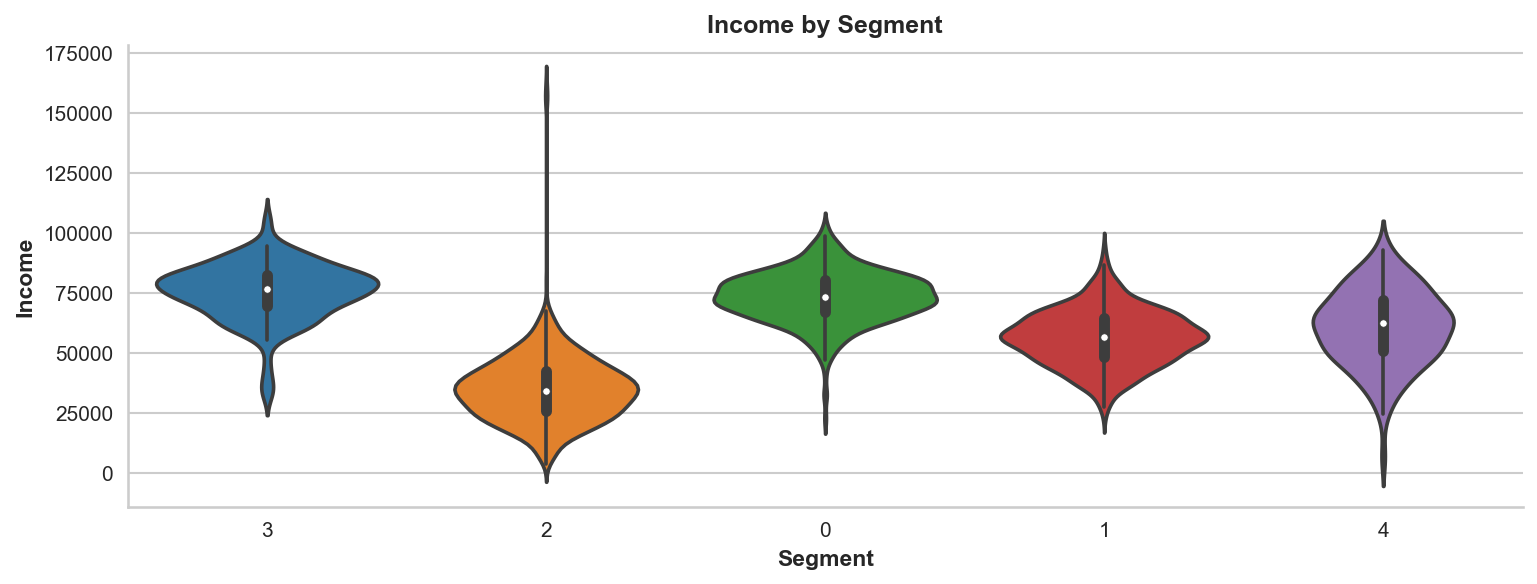

In [369]:
plot_violin(x= 'segment', 
            y= 'income', 
            df= df_clean)

# Summary and Recommendation